# Prepare Environment and Data

In [0]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 378.8MB 53kB/s 
     |████████████████████████████████| 61kB 23.6MB/s 
     |████████████████████████████████| 4.1MB 34.1MB/s 
     |████████████████████████████████| 450kB 31.7MB/s 


In [0]:
# if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Import tools
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import itertools as IT
import matplotlib.pyplot as plt
import csv
plt.style.use(['seaborn'])
from PIL import Image
import requests
from io import BytesIO
import ast

# PyDrive Configs
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Gcloud Configs
from google.cloud import storage
from google.colab import auth
auth.authenticate_user()
from oauth2client.service_account import ServiceAccountCredentials
import os

%matplotlib inline
import matplotlib.pyplot as ply

import os, json
from glob import glob

# TF Configs
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

import tensorflow as tf

     |████████████████████████████████| 993kB 3.5MB/s 


W0729 01:02:03.370087 140710937155456 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
use_cols = ['transaction_id', 'seller_badge', 'category', 'payment_method', 'from_city', 'to_city', 'courier', 'logistc_fee', 'accepted_time_dt']

df = pd.read_csv(
  filepath_or_buffer= 'https://storage.googleapis.com/bukalapak-data/Transactions_Aug_2018_with_buka_lost.csv', parse_dates = True, infer_datetime_format = True, usecols = use_cols)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df['accepted_time_dt'] = pd.to_datetime(df['accepted_time_dt'])
df.drop_duplicates(subset="transaction_id", inplace = True)

In [0]:
df['accepted_time_dt'] = df['accepted_time_dt'].dt.round('15min')
df = df.set_index(pd.DatetimeIndex(df['accepted_time_dt']))
df = df[~df['accepted_time_dt'].isna()]

In [0]:
df.head()

,transaction_id,seller_badge,category,payment_method,from_city,to_city,courier,logistc_fee,accepted_time_dt
accepted_time_dt,,,,,,,,,
2018-08-02 22:30:00,9.80885e+08,Juragan,Aksesoris Mobil,atm,Kab. Bekasi,Morowali Utara,JNE REG,77000.0,2018-08-02 22:30:00
2018-08-03 20:15:00,9.83542e+08,Good Seller,Aksesoris Motor,cimb_clicks,Tangerang Selatan,Tangerang Selatan,Wahana Tarif Normal,5000.0,2018-08-03 20:15:00
2018-08-03 18:30:00,9.84003e+08,Good Seller,Spare Part & Tools Handphone,atm,Jakarta Pusat,Tulungagung,J&T REG,30000.0,2018-08-03 18:30:00
2018-08-02 14:00:00,9.99051e+08,Calon Juragan,Kamar Mandi,atm,Tangerang,Makassar,J&T REG,396000.0,2018-08-02 14:00:00
2018-08-02 08:45:00,9.99681e+08,Juragan,Perawatan Tubuh,virtual_account,Jakarta Selatan,Depok,JNE REG,9000.0,2018-08-02 08:45:00


In [0]:
logistic_fee = df.groupby(df.index).sum()

In [0]:
categories = df[['category']]
def conv_category(cat):
  cat_list = ["Aksesoris Handphone", "Sparepart Motor", "HP & Smartphone", "Aksesoris Motor", "Mainan"]
  if(cat not in cat_list):
    return "Other"
  else: return cat

categories['category'] = categories['category'].apply(lambda x: conv_category(x))

categories = pd.get_dummies(categories, 'category').groupby(df.index).sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
seller = df[['seller_badge']]
seller = pd.get_dummies(seller, 'seller_badge').groupby(df.index).sum()
seller

,seller_badge_BL_User,seller_badge_Calon Juragan,seller_badge_Good Seller,seller_badge_Juragan,seller_badge_Pedagang,seller_badge_Pedagang Besar,seller_badge_Recommended Seller,seller_badge_Top Seller,seller_badge_Trusted Seller
accepted_time_dt,,,,,,,,,
2018-08-01 00:00:00,0.0,2.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0
2018-08-01 00:15:00,3.0,7.0,1.0,7.0,6.0,14.0,0.0,0.0,0.0
2018-08-01 00:30:00,2.0,3.0,3.0,5.0,2.0,13.0,1.0,0.0,0.0
2018-08-01 00:45:00,3.0,7.0,3.0,10.0,4.0,18.0,1.0,1.0,0.0
2018-08-01 01:00:00,2.0,0.0,2.0,8.0,5.0,6.0,0.0,0.0,0.0
2018-08-01 01:15:00,1.0,5.0,2.0,11.0,8.0,16.0,1.0,0.0,0.0
2018-08-01 01:30:00,4.0,7.0,0.0,21.0,12.0,14.0,2.0,0.0,0.0
2018-08-01 01:45:00,1.0,12.0,4.0,9.0,9.0,13.0,2.0,0.0,0.0
2018-08-01 02:00:00,1.0,2.0,0.0,16.0,7.0,8.0,0.0,0.0,0.0


In [0]:
volume = df[['transaction_id']].groupby(df.index).count()
volume.head()

,transaction_id
accepted_time_dt,
2018-08-01 00:00:00,9
2018-08-01 00:15:00,38
2018-08-01 00:30:00,29
2018-08-01 00:45:00,47
2018-08-01 01:00:00,23


In [0]:
day_of_week = pd.DataFrame(pd.DataFrame(pd.Series(volume.index))['accepted_time_dt'].apply(lambda x: x.weekday())).rename(columns = {'accepted_time_dt': 'day'})
day_of_week['day'] = day_of_week['day'].apply(lambda x: str(x))
day_of_week = pd.get_dummies(day_of_week).iloc[0:3000,]

In [0]:
hour_of_day = pd.DataFrame(pd.DataFrame(pd.Series(volume.index))['accepted_time_dt'].apply(lambda x: x.hour)).rename(columns = {'accepted_time_dt': 'hour'})
hour_of_day['hour'] = hour_of_day['hour'].apply(lambda x: str(x))
hour_of_day = pd.get_dummies(hour_of_day).iloc[0:3000,]

In [0]:
quarter_of_hour = pd.DataFrame(pd.DataFrame(pd.Series(volume.index))['accepted_time_dt'].apply(lambda x: x.minute/15)).rename(columns = {'accepted_time_dt': 'quarter'})
quarter_of_hour['quarter'] = quarter_of_hour['quarter'].apply(lambda x: str(x))
quarter_of_hour = pd.get_dummies(quarter_of_hour).iloc[0:3000,]

In [0]:
from functools import reduce
data = reduce(lambda x,y: pd.merge(x,y, on = 'accepted_time_dt', how='outer'), [volume, seller, categories, logistic_fee, pd.DataFrame(pd.Series(volume.index))])
data = data.iloc[0:3000,]
data['day_of_week'] = data['accepted_time_dt'].apply(lambda x: x.weekday())
data['hour_of_day'] = data['accepted_time_dt'].apply(lambda x: x.hour)
data.tail(20)

,accepted_time_dt,transaction_id,seller_badge_BL_User,seller_badge_Calon Juragan,seller_badge_Good Seller,seller_badge_Juragan,seller_badge_Pedagang,seller_badge_Pedagang Besar,seller_badge_Recommended Seller,seller_badge_Top Seller,seller_badge_Trusted Seller,category_Aksesoris Handphone,category_Aksesoris Motor,category_HP & Smartphone,category_Mainan,category_Other,category_Sparepart Motor,logistc_fee,day_of_week,hour_of_day
2980,2018-09-01 01:00:00,259,0.0,53.0,15.0,77.0,5.0,28.0,9.0,0.0,0.0,31.0,3.0,10.0,7.0,205.0,3.0,4124500.0,5,1
2981,2018-09-01 01:15:00,247,4.0,37.0,6.0,44.0,6.0,61.0,15.0,0.0,0.0,25.0,3.0,9.0,4.0,200.0,6.0,4740750.0,5,1
2982,2018-09-01 01:30:00,136,0.0,7.0,3.0,42.0,13.0,23.0,8.0,0.0,0.0,17.0,8.0,1.0,3.0,102.0,5.0,2037400.0,5,1
2983,2018-09-01 01:45:00,107,0.0,16.0,12.0,39.0,5.0,24.0,2.0,0.0,0.0,1.0,3.0,1.0,2.0,94.0,6.0,2106475.0,5,1
2984,2018-09-01 02:00:00,93,0.0,26.0,9.0,15.0,3.0,30.0,7.0,0.0,0.0,4.0,2.0,1.0,2.0,83.0,1.0,1977200.0,5,2
2985,2018-09-01 02:15:00,76,0.0,7.0,13.0,28.0,5.0,13.0,9.0,0.0,0.0,1.0,7.0,1.0,0.0,64.0,3.0,1706200.0,5,2
2986,2018-09-01 02:30:00,172,0.0,15.0,7.0,77.0,8.0,52.0,11.0,0.0,0.0,3.0,1.0,0.0,2.0,163.0,3.0,4237550.0,5,2
2987,2018-09-01 02:45:00,109,0.0,17.0,10.0,59.0,2.0,14.0,3.0,0.0,0.0,2.0,1.0,1.0,2.0,103.0,0.0,2415600.0,5,2
2988,2018-09-01 03:00:00,72,0.0,5.0,16.0,17.0,4.0,27.0,0.0,0.0,0.0,1.0,13.0,0.0,2.0,55.0,1.0,1144250.0,5,3
2989,2018-09-01 03:15:00,73,0.0,2.0,10.0,6.0,12.0,28.0,10.0,0.0,0.0,5.0,2.0,0.0,0.0,66.0,0.0,1723350.0,5,3


In [0]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(8,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

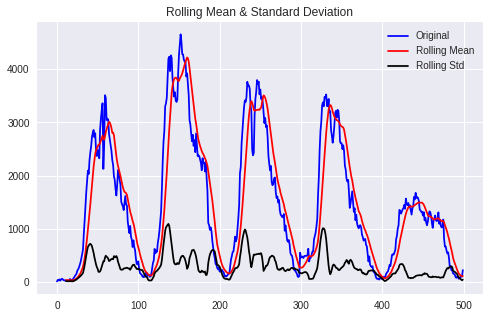

Results of Dickey-Fuller Test:
Test Statistic                  -4.673602
p-value                          0.000094
#Lags Used                      18.000000
Number of Observations Used    481.000000
Critical Value (1%)             -3.444018
Critical Value (5%)             -2.867568
Critical Value (10%)            -2.569980
dtype: float64


In [0]:
test_stationarity(data['transaction_id'][:500])

# NNs

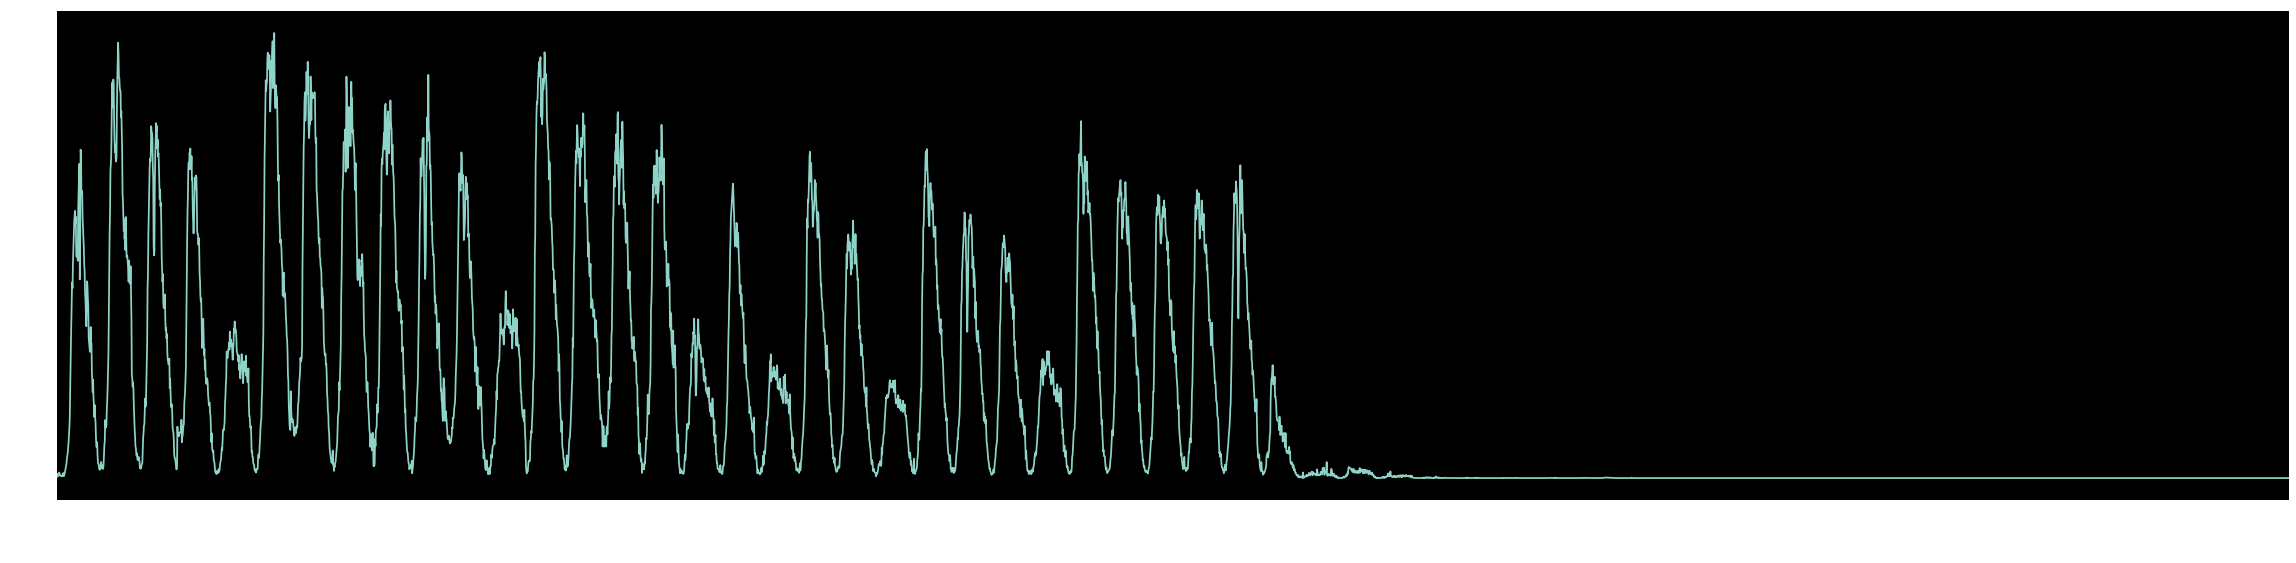

In [0]:
plt.figure(figsize=(40,10))
data['transaction_id'].plot()
ply.show()

In [0]:
train_test_split = 0.9
length = len(data.index)
train_data = data.iloc[0:int(length*train_test_split), ]
test_data = data.iloc[int(length*train_test_split+1):length, ]

## Checking how Stationary the data is

In [0]:
def window_data(dataset, pick = 1):
    X = list()
    Y = list()
    for i in range(len(dataset) - pick):
        X.append(dataset[i:i+pick][0])
        Y.append(dataset[i+pick])
    return np.array(X), np.array(Y) 

# split a univariate sequence into samples
def advanced_window(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

## Creating Windows of the data to turn the problem in a supervised learning problem

In [0]:
def window_data(dataset, pick = 1):
    X = list()
    Y = list()
    for i in range(len(dataset) - pick):
        X.append(dataset[i:i+pick][0])
        Y.append(dataset[i+pick])
    return np.array(X), np.array(Y) 

In [0]:
# split a univariate sequence into samples
def advanced_window(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

## Differencing the data

In [0]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [0]:
diffed = difference(data['transaction_id'],1)

# using pandas
# diffed = df['#Passengers'].diff()


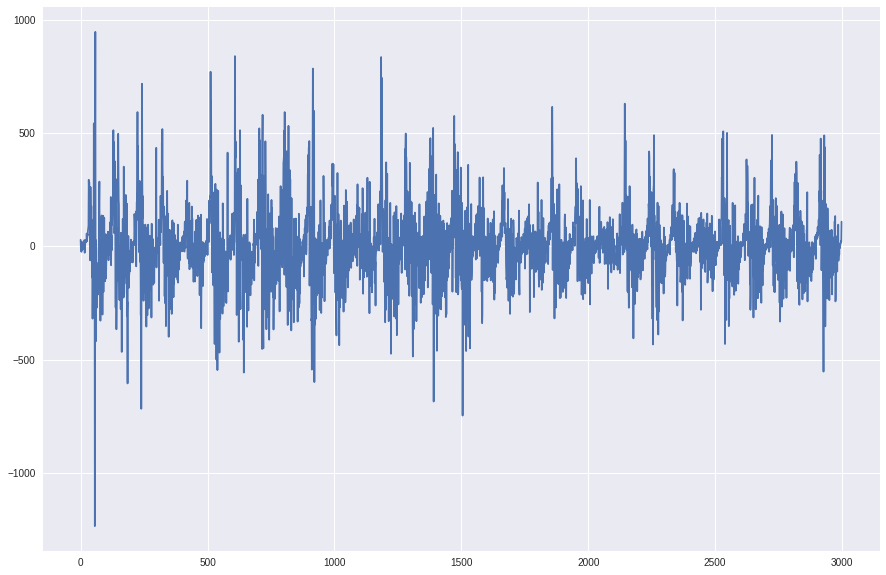

In [0]:
plt.figure(figsize=(15,10))
plt.plot(diffed)
plt.show()

### Scaling the data

we scale the data between 0 and 1

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

transactions = scaler.fit_transform(data['transaction_id'].values.astype('float32').reshape(-1,1))

In [0]:
def train_test_split(dataset, test_size = 0.2):
    ratio = int((1 - test_size) * len(dataset))
    return dataset[:ratio, :], dataset[ratio:,:]
    
train, test = train_test_split(transactions, test_size = 0.1)

In [0]:
X_train, y_train = window_data(train)
X_test, y_test = window_data(test)

In [0]:
X_train[0]

array([0.], dtype=float32)

In [0]:
pXtest = pd.Series([p[0] for p in X_test])
pXtest.index = list(range(len(data) - len(test) + 1, len(data)))

In [0]:
X_train.reshape(-1,1)

array([[0.        ],
       [0.00610526],
       [0.00421053],
       ...,
       [0.02484211],
       [0.01768421],
       [0.01494737]], dtype=float32)

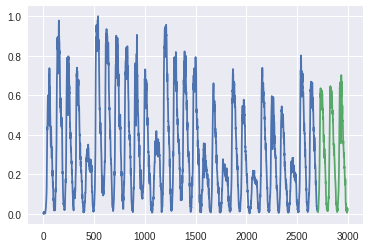

In [0]:
plt.plot(X_train.reshape(-1,1))
plt.plot(pXtest)
plt.show()

## MLP

In [0]:
def window(num):
  df_window = data.iloc[num-40:num]
  output = np.array(df_window['transaction_id'])
  # output = np.append(output, df_window['category_Other'])
  output = np.append(output, day_of_week.iloc[num+1])
  output = np.append(output, hour_of_day.iloc[num+1])
  output = np.append(output, quarter_of_hour.iloc[num+1])
  return output

mlp_x = np.array([window(40)])

for i in range(len(data.index)-42):
  mlp_x = np.vstack([mlp_x, np.array([window(i+41)])])

mlp_y = np.array(data.iloc[40:]['transaction_id'])

split = 0.8

mlp_x_train = mlp_x[:int(split * len(mlp_x))]
mlp_y_train = mlp_y[:int(split * len(mlp_x))]
mlp_x_test = mlp_x[int(split * len(mlp_x))+1:]
mlp_y_test = mlp_y[int(split * len(mlp_x))+1:]

In [0]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout

In [0]:
model = Sequential(name = "MLP_forecaster")
model.add(Dense(75, input_dim=75, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(56, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

opt = optimizers.SGD(lr=0.00001, clipvalue=0.5)

model.compile(loss='mean_squared_error', optimizer="Adam")

model.summary()

W0729 01:04:03.048731 140710937155456 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "MLP_forecaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 75)                5700      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               19456     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 56)                7224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 57        
Total params: 65,333
Trainable params: 65,333
Non-trainable params: 0
_________________________________________________________________


In [0]:
mlp_x_train.shape

(2367, 75)

In [0]:
model.fit(mlp_x_train, mlp_y_train, epochs = 1000, batch_size = 32)

Epoch 1/1000
2367/2367 [==============================] - 0s 76us/sample - loss: 64.6641
Epoch 2/1000
2367/2367 [==============================] - 0s 71us/sample - loss: 72.6147
Epoch 3/1000
2367/2367 [==============================] - 0s 70us/sample - loss: 60.8368
Epoch 4/1000
2367/2367 [==============================] - 0s 69us/sample - loss: 67.2204
Epoch 5/1000
2367/2367 [==============================] - 0s 71us/sample - loss: 125.9113
Epoch 6/1000
2367/2367 [==============================] - 0s 66us/sample - loss: 197.6467
Epoch 7/1000
2367/2367 [==============================] - 0s 76us/sample - loss: 196.0564
Epoch 8/1000
2367/2367 [==============================] - 0s 69us/sample - loss: 117.0534
Epoch 9/1000
2367/2367 [==============================] - 0s 66us/sample - loss: 144.0563
Epoch 10/1000
2367/2367 [==============================] - 0s 65us/sample - loss: 155.8768
Epoch 11/1000
2367/2367 [==============================] - 0s 65us/sample - loss: 102.2213
Epoch 12/100

## Single-Step (MLP)

In [0]:
mlp_y_pred = model.predict(mlp_x_test)
mlp_y_pred = pd.Series([p[0] for p in mlp_y_pred])
mlp_y_pred.index = list(range(len(data) - len(mlp_x_test), len(data)))

In [0]:
persistence = data['transaction_id'].shift(periods=1)[1:]

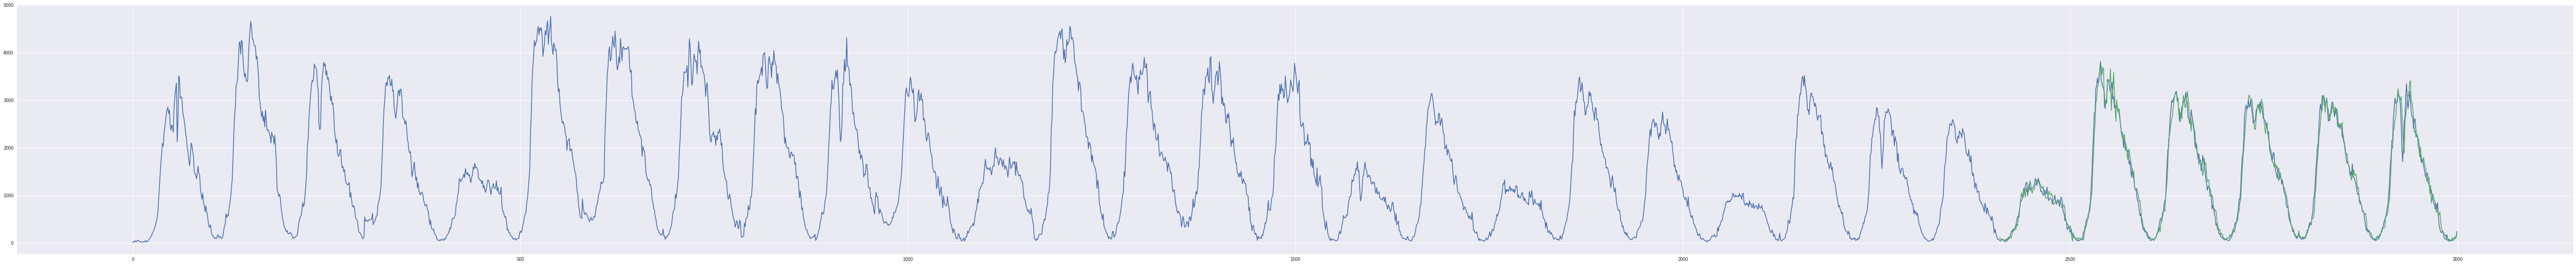

In [0]:
plt.figure(figsize=(100,10))

# plt.plot(scaler.inverse_transform(transactions+1.75))
# plt.plot(scaler.inverse_transform(model.predict(X_train)+0.75))

# plt.plot(scaler.inverse_transform(transactions))
# plt.plot(scaler.inverse_transform(model.predict(X_train)))

plt.plot(data['transaction_id'])

# plt.plot(persistence)

plt.plot(mlp_y_pred)
plt.show()

## Multi-Step (MLP)

In [0]:
def multistep_pred():
  walk_fwd = np.copy(mlp_x_test)
  predictions = np.array([0])
  for i in range(len(mlp_x_test)-1):
    inputs = walk_fwd[i:i+1]
    pred = model.predict(inputs)[0][0]
    predictions = np.vstack([predictions, np.array([pred])])
    walk_fwd[i+1:i+2][0][39] = pred
    # print("Single-Step Prediction:", model.predict(mlp_x_test[i:i+1])[0][0])
    # print("Multi-Step Prediction:", pred)
    # print("Ground-Truth:", mlp_y_test[i])
    # print("\n")
  return np.delete(predictions, 0)


multistep = pd.Series(multistep_pred())
multistep.index = list(range(len(data) - len(mlp_x_test) + 1, len(data)))

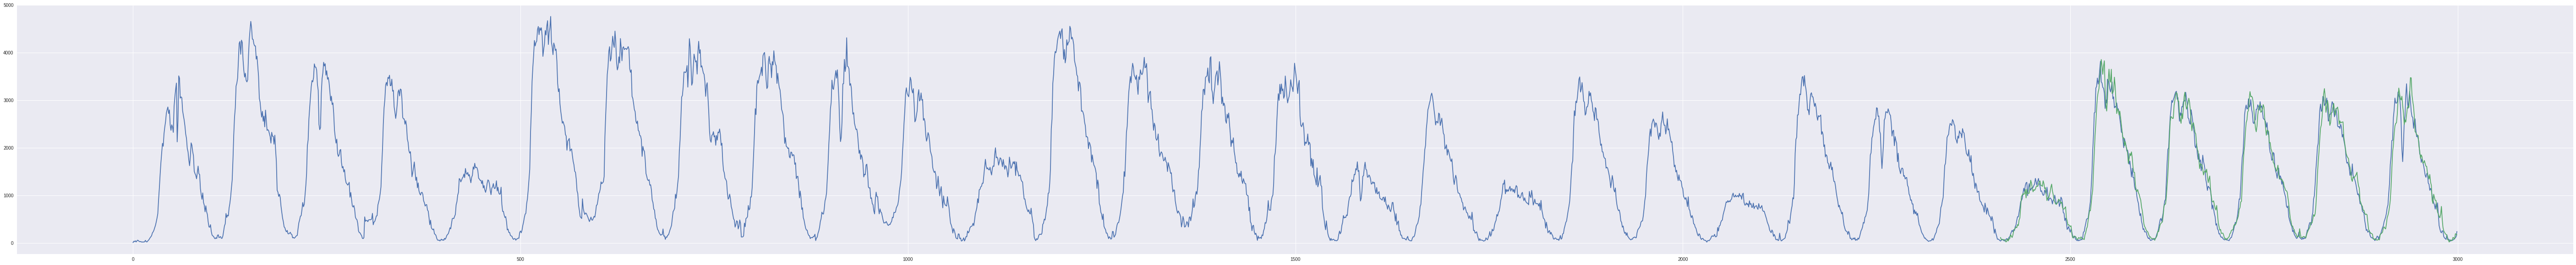

In [0]:
plt.figure(figsize=(100,10))

plt.plot(data['transaction_id'])

# plt.plot(persistence)

plt.plot(multistep)
plt.show()

## LSTM

In [0]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [0]:
model = Sequential()
model.add(LSTM(256, input_shape = (1,1)))
model.add(Dense(1)) # regressing to a single value

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train.shape

(2699, 1, 1)

In [0]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_train.shape[1])

In [0]:
X_train.shape

(2699, 1, 1)

In [0]:

model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Train on 2699 samples
Epoch 1/10
2699/2699 [==============================] - 1s 198us/sample - loss: 0.1046
Epoch 2/10
2699/2699 [==============================] - 0s 40us/sample - loss: 0.0350
Epoch 3/10
2699/2699 [==============================] - 0s 38us/sample - loss: 0.0228
Epoch 4/10
2699/2699 [==============================] - 0s 37us/sample - loss: 0.0134
Epoch 5/10
2699/2699 [==============================] - 0s 37us/sample - loss: 0.0059
Epoch 6/10
2699/2699 [==============================] - 0s 38us/sample - loss: 0.0022
Epoch 7/10
2699/2699 [==============================] - 0s 39us/sample - loss: 0.0013
Epoch 8/10
2699/2699 [==============================] - 0s 38us/sample - loss: 0.0012
Epoch 9/10
2699/2699 [==============================] - 0s 38us/sample - loss: 0.0012
Epoch 10/10
2699/2699 [==============================] - 0s 36us/sample - loss: 0.0012


In [0]:
y_pred = model.predict(X_test)

In [0]:
X_test[0]

array([[0.01452632]], dtype=float32)

## Single-Step (LSTM)

In [0]:
pytest = scaler.inverse_transform(model.predict(X_test))
pytest = pd.Series([p[0] for p in pytest])
pytest.index = list(range(len(data) - len(test) + 1, len(data)))

In [0]:
persistence = scaler.inverse_transform(transactions)
persistence = pd.Series([p[0] for p in persistence]).shift(periods=1)[1:]

In [0]:
plt.figure(figsize=(200,20))

# plt.plot(scaler.inverse_transform(transactions+1.75))
# plt.plot(scaler.inverse_transform(model.predict(X_train)+0.75))

plt.plot(scaler.inverse_transform(transactions))
# plt.plot(scaler.inverse_transform(model.predict(X_train)))

plt.plot(persistence)

plt.plot(pytest)
plt.show()

In [0]:
n = 100
print(X_test[n-1:n])
print(model.predict(X_test[n-1:n]))
print("\n")
print(X_test[n:n+1])
print(model.predict(X_test[n:n+1]))
print("\n")
print(X_test[n+1:n+2])
print(model.predict(X_test[n+1:n+2]))
print("\n")

[[[0.21009362]]]
[[0.20680153]]


[[[0.21016198]]]
[[0.20686665]]


[[[0.21022731]]]
[[0.20692885]]




ValueError: ignored

## Multi-Step (LSTM)

In [0]:
def multistep_pred(X_test):
  pred = np.array([model.predict(X_test[0:1])])
  x = np.array([])
  print("Prediction:", pred)
  print("X_test Val:", np.array([X_test[1]]))
  print("\n")

  for i in range(len(X_test)-2):
    pred = np.array([model.predict(pred)])
    x = np.append(x, pred)
    print("Prediction:", pred)
    print("X_test Val:", np.array([X_test[i+2]]))
    print("\n")
  # return(X_test)

multistep_pred(X_test)

# multistep = pd.Series(multistep_pred(X_test))
# multistep.index = list(range(len(data) - len(test) + 1, len(data)))

Prediction: [[[0.02458956]]]
X_test Val: [[[0.02458956]]]


Prediction: [[[0.03376968]]]
X_test Val: [[[0.03376968]]]


Prediction: [[[0.04216285]]]
X_test Val: [[[0.04216285]]]


Prediction: [[[0.0498521]]]
X_test Val: [[[0.0498521]]]


Prediction: [[[0.05690951]]]
X_test Val: [[[0.05690951]]]


Prediction: [[[0.06339797]]]
X_test Val: [[[0.06339797]]]


Prediction: [[[0.06937261]]]
X_test Val: [[[0.06937261]]]


Prediction: [[[0.07488194]]]
X_test Val: [[[0.07488194]]]


Prediction: [[[0.07996885]]]
X_test Val: [[[0.07996885]]]


Prediction: [[[0.08467141]]]
X_test Val: [[[0.08467141]]]


Prediction: [[[0.08902348]]]
X_test Val: [[[0.08902348]]]


Prediction: [[[0.09305532]]]
X_test Val: [[[0.09305532]]]


Prediction: [[[0.09679403]]]
X_test Val: [[[0.09679403]]]


Prediction: [[[0.10026399]]]
X_test Val: [[[0.10026399]]]


Prediction: [[[0.10348712]]]
X_test Val: [[[0.10348712]]]


Prediction: [[[0.10648324]]]
X_test Val: [[[0.10648324]]]


Prediction: [[[0.1092703]]]
X_test Val: [[

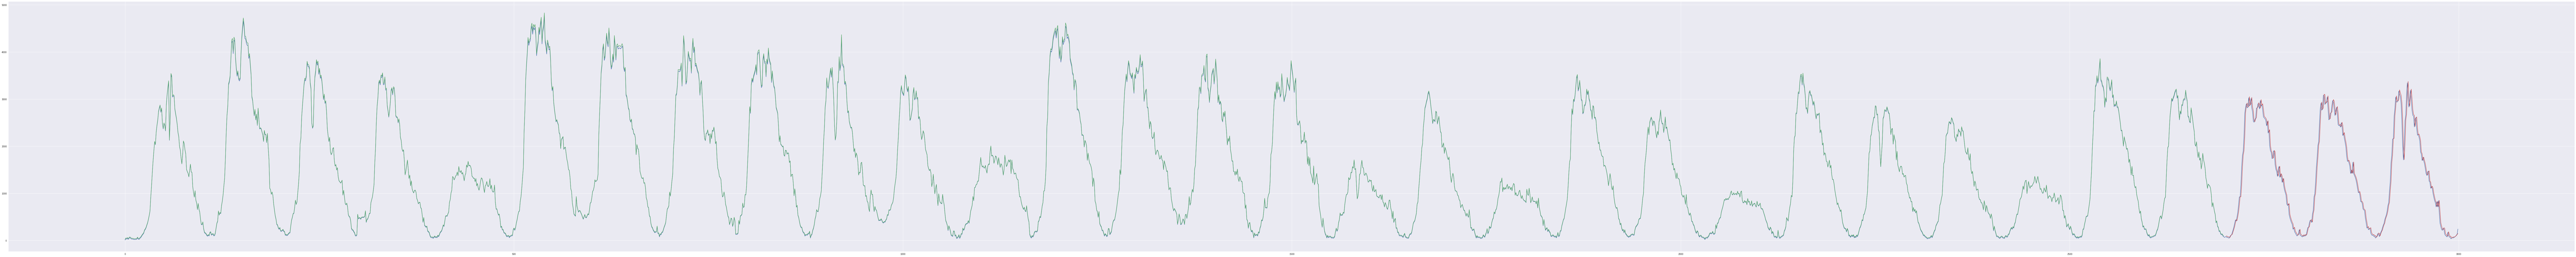

In [0]:
plt.figure(figsize=(200,20))

# plt.plot(scaler.inverse_transform(transactions+1.75))
# plt.plot(scaler.inverse_transform(model.predict(X_train)+0.75))

plt.plot(scaler.inverse_transform(transactions))
plt.plot(scaler.inverse_transform(model.predict(X_train)))

# plt.plot(persistence)

plt.plot(pytest)
plt.show()

## Export Model

In [0]:
model.save("./buka_forecasting_mlp_v1.h5")

In [0]:
# Upload to Gdrive
from google.colab import drive
drive.mount('drive')
!cp buka_forecasting_mlp_v1.h5 drive/My\ Drive/

Mounted at drive


# Set up Prophet

In [0]:
# Install Libraries (This may need to be done first each time the notebook is used here.  Takes a few minutes to install)
from IPython.display import clear_output
try:
  !pip install pystan
  !pip install --upgrade git+https://github.com/jroakes/google-analytics.git
  !pip install fbprophet
except:
  pass
finally:
  clear_output()
  print('All Loaded')
  
from fbprophet import Prophet

All Loaded


In [0]:
data['y'] = data['transaction_id']
data['ds'] = data.index

In [0]:
m = Prophet(changepoint_prior_scale=0.01).fit(data)

In [0]:
future = m.make_future_dataframe(periods=1000, freq='H')
forecast = m.predict(future)
future

,ds
0,2018-08-01 00:00:00
1,2018-08-01 00:15:00
2,2018-08-01 00:30:00
3,2018-08-01 00:45:00
4,2018-08-01 01:00:00
5,2018-08-01 01:15:00
6,2018-08-01 01:30:00
7,2018-08-01 01:45:00
8,2018-08-01 02:00:00
9,2018-08-01 02:15:00


In [0]:
forecast

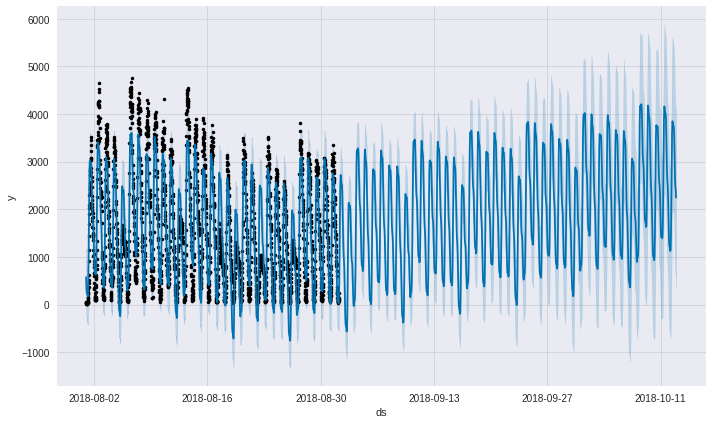

In [0]:
fcst = m.predict(future)
fig = m.plot(fcst)

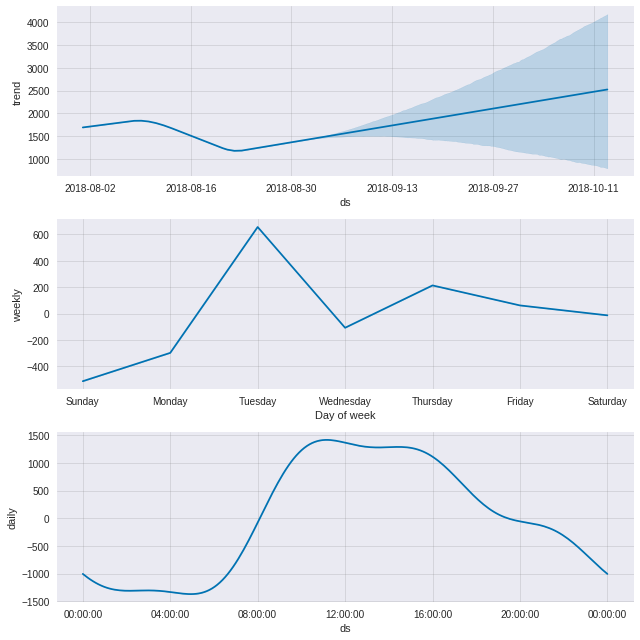

In [0]:
fig = m.plot_components(fcst)

# Defunct

In [0]:
# Import data
df = pd.read_csv(filepath_or_buffer= 'https://storage.googleapis.com/bukalapak/order_buka.csv')

# Extract metadata column
details_list = df['details'].tolist()
df.drop(columns=['details'], inplace=True)

# Parse into json then format into a dataframe
details = []
for detail in details_list:
  details.append(ast.literal_eval(detail))
df2 = json_normalize(details)

# Join back into original dataframe
df = df.join(df2)

In [0]:
details_list = df['Raw.lineitems'].tolist()
df.drop(columns=['Raw.lineitems'], inplace=True)

details = []
for i in range(len(details_list)):
  details.append(details_list[i][0])
  

df2 = json_normalize(details)
df = df.join(df2)

In [0]:
details_list = df['images'].tolist()
df.drop(columns=['images'], inplace=True)

details = []
for i in range(len(details_list)):
  details.append(details_list[i][0])

df2 = pd.Series(details)
df['im_url'] = df2

In [0]:
df = df[df['status'] != 'cancelled']

In [0]:
df = df[['extOrderId', 'createdAt', 'amount', 'Raw.from.city', 'Raw.logistic.name', 'Raw.logistic.priceAmount', 'Raw.premiumAmount', 'category', 'qty', 'im_url']]

In [0]:
df

,extOrderId,createdAt,amount,Raw.from.city,Raw.logistic.name,Raw.logistic.priceAmount,Raw.premiumAmount,category,qty,im_url
0,BL19137O5IU7INV,2019-05-29 00:00:00,1780000,Jakarta Barat,JNE REG,900000.0,6700,Elektronik,1,https://s3.bukalapak.com/img/3190127706/origin...
1,BL19137O5JRCINV,2019-05-29 00:00:00,209900000,Bekasi,GO-SEND Instant,2000000.0,529800,Handphone,1,https://s1.bukalapak.com/img/63080905401/origi...
2,BL19137O5KGCINV,2019-05-29 00:00:00,10800000,Jakarta Barat,JNE REG,2700000.0,22400,Fashion Pria,1,https://s3.bukalapak.com/img/8414984795/origin...
3,BL19137O5M5MINV,2019-05-29 00:00:00,3120000,Surabaya,J&T REG,700000.0,9600,Handphone,26,https://s4.bukalapak.com/img/450278165/origina...
7,BL19137O5WZWINV,2019-05-29 00:00:00,28150000,Jakarta Pusat,SiCepat BEST,5200000.0,83400,Industrial,1,https://s3.bukalapak.com/img/8494403725/origin...
8,BL19137O5Y3WINV,2019-05-29 00:00:00,3890000,Jakarta Barat,JNE REG,1100000.0,12500,Rumah Tangga,1,https://s0.bukalapak.com/img/0243658702/origin...
9,BL19137O61R2INV,2019-05-29 00:00:00,10820000,Bekasi,SiCepat REG,1000000.0,29600,Elektronik,1,https://s4.bukalapak.com/img/4887675901/origin...
10,BL19137O63Y2INV,2019-05-30 00:00:00,25000000,Jakarta Pusat,J&T REG,1000000.0,65000,Fashion Pria,1,https://s0.bukalapak.com/img/0608089883/origin...
11,BL19137O6417INV,2019-05-30 00:00:00,25000000,Jakarta Pusat,J&T REG,1000000.0,65000,Fashion Pria,1,https://s0.bukalapak.com/img/0608089883/origin...
12,BL19137O641CINV,2019-05-30 00:00:00,25000000,Jakarta Pusat,J&T REG,1000000.0,65000,Fashion Pria,1,https://s0.bukalapak.com/img/0608089883/origin...


In [0]:
df['createdAt'] = pd.to_datetime(df['createdAt'])

In [0]:
df.dtypes

extOrderId                          object
createdAt                   datetime64[ns]
amount                               int64
Raw.from.city                       object
Raw.logistic.name                   object
Raw.logistic.priceAmount           float64
Raw.premiumAmount                    int64
category                            object
qty                                  int64
im_url                              object
dtype: object

In [0]:
data = df.groupby([df['createdAt'].dt.date]).mean()
data

,amount,Raw.logistic.priceAmount,Raw.premiumAmount,qty
createdAt,,,,
2019-05-29,3.835143e+07,1.942857e+06,99142.857143,4.571429
2019-05-30,1.507398e+08,3.284474e+06,377409.650544,1.550567
2019-05-31,1.681872e+08,3.356956e+06,424561.091371,1.424619
2019-06-01,1.522697e+08,2.970557e+06,386783.800716,1.496420
2019-06-02,1.535323e+08,2.996509e+06,389563.888889,1.512438
2019-06-03,1.599473e+08,3.160053e+06,404913.679654,1.440260
2019-06-04,1.558314e+08,2.883383e+06,395901.335113,1.841121
2019-06-05,1.241992e+08,2.494286e+06,314487.964602,1.625664
2019-06-06,1.383312e+08,3.128420e+06,347833.877551,1.728280
